In [30]:
import json
import math
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import pprint
pp = pprint.PrettyPrinter(indent=2)

filename = "/Users/ken/Downloads/montreal_final.json"

## Read data

In [2]:
with open(filename) as file:
    cm = json.load(file)
    
len(cm["CityObjects"])

28018

## Totals

In [3]:
totals = {}
for co_id, co in cm["CityObjects"].items():
    if co["type"] in totals:
        totals[co["type"]] += 1
    else:
        totals[co["type"]] = 1
        
for co_type, co_total in totals.items():
    print(str(co_type) + ": " + str(co_total))

Road: 4387
Building: 19430
LandUse: 4120
PlantCover: 80
WaterBody: 1


## Load roads and buildings into PyVista

In [4]:
roads = {}
buildings = {}

for co_id in list(cm["CityObjects"]):
    co = cm["CityObjects"][co_id]
    
    if co["type"] == "Road":
        roads[co_id] = {}
        for geom in co["geometry"]:
            if geom["type"] == "MultiLineString":
                geom_line = geom
            if geom["type"] == "MultiSurface":
                geom_surface = geom
                
        lines = []
        lines_vertices = []
        num_lines = 0
        for segment in geom_line["boundaries"]:
            lines.extend([2, 2*num_lines, 2*num_lines+1])
            lines_vertices.extend([cm["vertices"][segment[0]], cm["vertices"][segment[1]]])
            num_lines += 1
        if len(lines) > 0:
            mesh_lines = pv.PolyData(lines_vertices, lines=lines, n_lines=len(geom_line["boundaries"]))
            roads[co_id]["line"] = mesh_lines
        
        surface = []
        surface_vertices = []
        num_triangles = 0
        for triangle in geom_surface["boundaries"]:
            surface.extend([3, 3*num_triangles, 3*num_triangles+1, 3*num_triangles+2])
            surface_vertices.extend([cm["vertices"][triangle[0][0]], cm["vertices"][triangle[0][1]], cm["vertices"][triangle[0][2]]])
            num_triangles += 1
        if len(surface) > 0:
            mesh_surface = pv.PolyData(surface_vertices, surface, len(geom_surface["boundaries"]))
            roads[co_id]["surface"] = mesh_surface
            
    if co["type"] == "Building":
        buildings[co_id] = {}
        for geom in co["geometry"]:
            if geom["type"] == "Solid":
                geom_solid = geom
        
        surface = []
        surface_vertices = []
        num_triangles = 0
        for triangle in geom_solid["boundaries"][0]:
            surface.extend([3, 3*num_triangles, 3*num_triangles+1, 3*num_triangles+2])
            surface_vertices.extend([cm["vertices"][triangle[0][0]], cm["vertices"][triangle[0][1]], cm["vertices"][triangle[0][2]]])
            num_triangles += 1
        if len(surface) > 0:
            mesh_surface = pv.PolyData(surface_vertices, surface, len(geom_surface["boundaries"]))
            buildings[co_id]["surface"] = mesh_surface
        

## Remove roads and buildings without required geometries

In [5]:
for road_id in list(roads):
    if "surface" not in roads[road_id] or "line" not in roads[road_id]:
        roads.pop(road_id)
        
for building_id in list(buildings):
    if "surface" not in buildings[building_id]:
        buildings.pop(building_id)
        
print(str(len(roads)) + " roads")
print(str(len(buildings)) + " buildings")

1968 roads
19430 buildings


## For each road, find nearby buildings

In [6]:
def bbox_distance(pd1, pd2):
    xmin1 = pd1.bounds[0]
    xmax1 = pd1.bounds[1]
    ymin1 = pd1.bounds[2]
    ymax1 = pd1.bounds[3]
    zmin1 = pd1.bounds[4]
    zmax1 = pd1.bounds[5]
    xmin2 = pd2.bounds[0]
    xmax2 = pd2.bounds[1]
    ymin2 = pd2.bounds[2]
    ymax2 = pd2.bounds[3]
    zmin2 = pd2.bounds[4]
    zmax2 = pd2.bounds[5]
    if xmin1 > xmax2:
        xdist = xmin1-xmax2
    elif xmax1 < xmin2:
        xdist = xmin2-xmax1
    else:
        xdist = 0.0
    if ymin1 > ymax2:
        ydist = ymin1-ymax2
    elif ymax1 < ymin2:
        ydist = ymin2-ymax1
    else:
        ydist = 0.0
    if zmin1 > zmax2:
        zdist = zmin1-zmax2
    elif zmax1 < zmin2:
        zdist = zmin2-zmax1
    else:
        zdist = 0.0
    return math.sqrt(xdist*xdist + ydist*ydist + zdist*zdist)

search_radius = 20.0
for road_id in list(roads)[50:51]: # limited for testing
    nearby_buildings = []
    for building_id in list(buildings):
        if bbox_distance(roads[road_id]["surface"], buildings[building_id]["surface"]) < search_radius:
            nearby_buildings.append(building_id)
                    
    roads[road_id]["nearby_buildings"] = nearby_buildings

In [7]:
p = pv.Plotter()

for road_id in list(roads)[50:51]: # nice example road
    p.add_mesh(roads[road_id]["surface"], color="black")
    p.add_mesh(roads[road_id]["line"], color="yellow", line_width=2)
    if "nearby_buildings" in roads[road_id]:
        for building_id in roads[road_id]["nearby_buildings"]:
            p.add_mesh(buildings[building_id]["surface"], color="red", show_edges=True)

p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Compute width

In [24]:
for road_id in list(roads)[50:51]: # limited for testing
    
    # Create one mesh with nearby buildings
    vertices = []
    faces = []
    num_triangles = 0
    for building_id in roads[road_id]["nearby_buildings"]:
        for i in range(int(len(buildings[building_id]["surface"].faces)/4)):
            vertices.extend([buildings[building_id]["surface"].points[buildings[building_id]["surface"].faces[4*i+1]],
                             buildings[building_id]["surface"].points[buildings[building_id]["surface"].faces[4*i+2]],
                             buildings[building_id]["surface"].points[buildings[building_id]["surface"].faces[4*i+3]]])
            faces.extend([3, 3*num_triangles, 3*num_triangles+1, 3*num_triangles+2])
            num_triangles += 1
    nearby_buildings = pv.PolyData(vertices, faces, num_triangles)
    
    # Create slices
    interval = 5.0
    points_along_line = []
    line_slices = []
    line_slices_2d = []
    for i in range(int(len(roads[road_id]["line"].lines)/3)):
        line_start = roads[road_id]["line"].points[roads[road_id]["line"].lines[3*i+1]]
        line_end = roads[road_id]["line"].points[roads[road_id]["line"].lines[3*i+2]]
        line_vector = line_end-line_start # used to cut orthogonally along road line
        line_vector[2] = 0.0 # make sure the slices are vertical
        norm = np.linalg.norm(line_vector)
        print ("norm: " + str(norm))
        line_vector /= norm
        start = (norm-interval*math.floor(norm/interval))/2.0
        print ("start: " + str(start))
        for j in np.arange(start, norm, interval):
            print("current: " + str(j))
            points_along_line.append(line_vector*j+line_start)
            line_slices.append(nearby_buildings.slice(line_vector, points_along_line[-1]))
            centred_points = line_slices[-1].points-points_along_line[-1]
            points_2d = []
            for p in centred_points:
                magnitude = math.sqrt(p[0]*p[0]+p[1]*p[1])
                orientation = math.atan2(p[1], p[0])
                if orientation > -0.5*math.pi and orientation < 0.5*math.pi:
                    points_2d.append([magnitude, 0.0, p[2]])
                else:
                    points_2d.append([-magnitude, 0.0, p[2]])
            line_slices_2d.append(pv.PolyData(points_2d, lines=line_slices[-1].lines, n_lines=int(len(line_slices[-1].lines)/3)))
    roads[road_id]["slice_points"] = points_along_line
    roads[road_id]["slices"] = line_slices
    roads[road_id]["slices_2d"] = line_slices_2d

norm: 53.188813253457816
start: 1.594406626728908
current: 1.594406626728908
current: 6.594406626728908
current: 11.594406626728908
current: 16.594406626728908
current: 21.594406626728908
current: 26.594406626728908
current: 31.594406626728908
current: 36.59440662672891
current: 41.59440662672891
current: 46.59440662672891
current: 51.59440662672891


In [25]:
p = pv.Plotter()

for road_id in list(roads)[50:51]: # nice example road
    p.add_mesh(roads[road_id]["surface"], color="black")
    p.add_mesh(roads[road_id]["line"], color="yellow", line_width=2)
    if "nearby_buildings" in roads[road_id]:
        for building_id in roads[road_id]["nearby_buildings"]:
            p.add_mesh(buildings[building_id]["surface"], color="white", opacity=0.5)
    if "slices" in roads[road_id]:
        for s in roads[road_id]["slices"]:
            p.add_mesh(s, color="blue", line_width=2)
    points = pv.PolyData(roads[road_id]["slice_points"])
    p.add_points(points, color="red")
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

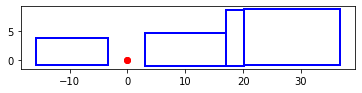

In [54]:
for road_id in list(roads)[50:51]: # nice example road
    if "slices" in roads[road_id]:
        slice_index = 6 # nice example slice
        
        for i in range(int(len(roads[road_id]["slices_2d"][slice_index].lines)/3)):
            plt.plot([roads[road_id]["slices_2d"][slice_index].points[roads[road_id]["slices_2d"][slice_index].lines[3*i+1]][0],
                      roads[road_id]["slices_2d"][slice_index].points[roads[road_id]["slices_2d"][slice_index].lines[3*i+2]][0]],
                     [roads[road_id]["slices_2d"][slice_index].points[roads[road_id]["slices_2d"][slice_index].lines[3*i+1]][2],
                      roads[road_id]["slices_2d"][slice_index].points[roads[road_id]["slices_2d"][slice_index].lines[3*i+2]][2]], 
                     'b-', lw=2)
plt.plot([[0, 0]], 'ro')
plt.axis('scaled')
plt.show()

In [ ]:
view_height = 5.0 # how high the viewpoint is
angular_interval = 0.1